Import necessary libraries. Feel free to import any more needed dependencies

In [45]:
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn import preprocessing
import numpy as np

Read in test and training data

In [41]:
train=pd.read_csv("clean_titanic.csv", 
            usecols=["Pclass","Sex","Age","SibSp","Parch","Survived"])
train.head()

,Pclass,Sex,Age,SibSp,Parch,Survived
0,3,male,22,1,0,0
1,1,female,38,1,0,1
2,3,female,26,0,0,1
3,1,female,35,1,0,1
4,3,male,35,0,0,0


Split and feature engineer

In [42]:
X=train.loc[:, train.columns != 'Survived']
y=train["Survived"]
X.loc[:,"Sex"]=X.Sex.replace({'male':1,'female':0})
#X.loc[:,"Embarked"]=X.Embarked.replace({'S':1,'C':2,'Q':3})
#X.loc[:,"Pclass"]=X.Pclass.replace({'3':0,'2':1,'1':-1})
#X["Age"]=np.array(list(map(lambda x : x/X)))
X=preprocessing.scale(X)
print(X)
X_train, X_test, y_train, y_test = train_test_split(X,y ,
                                   random_state=0,  
                                   shuffle=True)
print(X_train, X_test, y_train, y_test,sep="\n\n")


[[ 0.82737724  0.73769513 -0.59779181  0.43279337 -0.47367361]
 [-1.56610693 -1.35557354  0.63319476  0.43279337 -0.47367361]
 [ 0.82737724 -1.35557354 -0.29004517 -0.4745452  -0.47367361]
 ...
 [ 0.82737724 -1.35557354  0.01770148  0.43279337  2.00893337]
 [-1.56610693  0.73769513 -0.29004517 -0.4745452  -0.47367361]
 [ 0.82737724  0.73769513  0.1715748  -0.4745452  -0.47367361]]
[[ 0.82737724  0.73769513 -0.13617184 -0.4745452  -0.47367361]
 [ 0.82737724 -1.35557354 -0.98247511  3.15480905  2.00893337]
 [ 0.82737724  0.73769513  0.01770148  0.43279337 -0.47367361]
 ...
 [ 0.82737724  0.73769513  0.01770148 -0.4745452  -0.47367361]
 [ 0.82737724 -1.35557354  0.47932144  0.43279337 -0.47367361]
 [-0.36936484  0.73769513  2.32580129  0.43279337  0.76762988]]

[[ 0.82737724  0.73769513  0.01770148 -0.4745452  -0.47367361]
 [ 0.82737724  0.73769513  0.01770148 -0.4745452  -0.47367361]
 [ 0.82737724  0.73769513 -1.75184171  3.15480905  0.76762988]
 ...
 [ 0.82737724  0.73769513 -0.82860179

/var/folders/f9/705y45xj0gb72l7_vsbnsjt80000gn/T/ipykernel_54129/1543394684.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[:,"Sex"]=X.Sex.replace({'male':1,'female':0})
/var/folders/f9/705y45xj0gb72l7_vsbnsjt80000gn/T/ipykernel_54129/1543394684.py:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.loc[:,"Sex"]=X.Sex.replace({'male':1,'female':0})


train perspective models

In [101]:
def teacher(X_train, y_train,X_test,y_test,model):
    model.fit(X_train,y_train)
    modelP=model.predict(X_test)
    modelXor=np.sum(modelP^y_test)
    perc= 1-(modelXor/len(y_test))
    return modelXor,perc



svm=SVC(kernel='linear',C=1.0, random_state=0)
knn= KNeighborsClassifier(n_neighbors=5,p=2,metric='minkowski')
tree_mod= DecisionTreeClassifier(criterion="gini", max_depth=4, random_state=0)
lr=LogisticRegression()
gnb=GaussianNB()
#rf=RandomForestClassifier(max_depth=4,n_estimators=300)

model_names=['svm','knn','tree','lr','gnb']
model_tests=[svm,knn,tree_mod,lr,gnb]

ensemble=VotingClassifier(estimators=list(zip(model_names,model_tests)),voting='hard')

all_wrong=[]
all_perc_right=[]
for m in model_tests:
    wrong,perc_right=teacher(X_train, y_train,X_test,y_test,m)
    all_wrong.append(wrong)
    all_perc_right.append(perc_right)
results=list(zip(model_names,all_wrong,all_perc_right))
print(results)

ewrong,ep=teacher(X_train, y_train,X_test,y_test,ensemble)
print('Ensemble Wrong/percent_right: {}'.format([ewrong,ep]))

e2wrong,e2p=teacher(X_train, y_train,X_test,y_test,ensemble.set_params(svm='drop',gnb='drop'))
print(e2wrong,e2p)

all_wrong=np.append(all_wrong,[ewrong,e2wrong])
all_perc_right=np.append(all_perc_right,[ep,e2p,np.mean(all_perc_right)])
print(all_wrong,all_perc_right)

/Users/Launch/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/Launch/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be acce

[('svm', 49, 0.7802690582959642), ('knn', 43, 0.8071748878923767), ('tree', 41, 0.8161434977578476), ('lr', 44, 0.8026905829596412), ('gnb', 50, 0.7757847533632287)]
Ensemble Wrong/percent_right: [44, 0.8026905829596412]
40 0.820627802690583
[49 43 41 44 50 44 40] [0.78026906 0.80717489 0.8161435  0.80269058 0.77578475 0.80269058
 0.8206278  0.79641256]


/Users/Launch/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Plot metrics

['SVM 78.0%', 'KNN 80.7%', 'Decision Tree 81.6%', 'Log-Reg 80.3%', 'GNB 77.6%', 'All 80.3%', 'Ensemble 82.1%', 'Mean 79.6%']


Text(0.5, 0, '%')

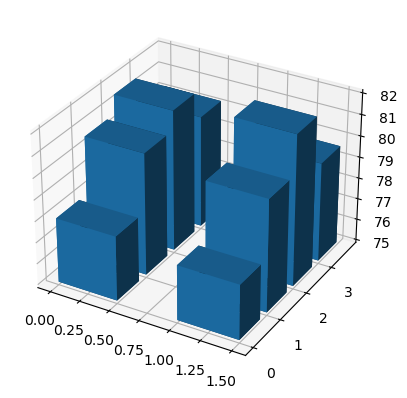

In [137]:
#plt.barh(np.linspace(0,len(all_perc_right),len(all_perc_right)),
 #       height=all_perc_right,
   #     label=[""])

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
l = np.arange(2)
w = np.arange(4)
mw, ml = np.meshgrid(w, l)
x, y = ml.ravel(), mw.ravel()

name=["SVM","KNN","Decision Tree","Log-Reg","GNB","All","Ensemble","Mean"]
label=list(map(lambda x: str(x[0])+" "+ str(x[1])+"%",zip(name,np.round(all_perc_right*100,1))))
print(label)
ax.bar3d(x,y,75,0.5,0.75,all_perc_right*100-75)
#for l, a, b, c in zip( label,x, y,all_perc_right):
   # ax.text(a, b, c, l, None)
ax.text(1,2,1,"I AM HERE",None)
ax.set_zlim(75,82)
ax.set_zlabel("%")


AttributeError: 'PolarAxes' object has no attribute 'get_bbox_to_anchor'

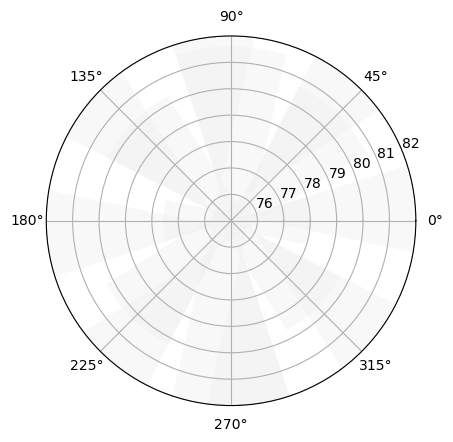

In [138]:
N = 8
theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)
radii = all_perc_right*100
width = np.pi / 4 * all_perc_right
colors = plt.cm.Pastel1(radii / 10.)

ax = plt.subplot(projection='polar')
ax.bar(theta, radii, width=width, bottom=0.0, color=colors, alpha=0.5)
ax.set_ylim(75,82)

plt.show()
